In [1]:
import tensorflow
import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

In [2]:
seed = 4242
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
csv_file = 'bert_training_data.csv'
data = pd.read_csv(csv_file)
print(data.head(5))

   Unnamed: 0                                              title  \
0           0  ANZ Bank New Zealand sells life insurance busi...   
1           1  Australia's Westpac cleared of rate rigging bu...   
2           2  Clear Channel Outdoor Holdings, Inc. Reports R...   
3           3  Clear Channel Outdoor Holdings, Inc. Reports R...   
4           4   BRIEF-Pembina Pipeline Corp Reports Q1 EPS $0.59   

   positive_change_+1day  negative_change_+1day  positive_change_+1week  \
0                      0                      1                       1   
1                      0                      1                       0   
2                      0                      1                       0   
3                      0                      1                       0   
4                      0                      1                       1   

   negative_change_+1week  
0                       0  
1                       1  
2                       1  
3                       1  


In [4]:
epochs = 15
learning_rate = 2e-4
batch_size = 265
max_length = 17
max_words = 10000

In [5]:
sequences = data['title'].values
labels = data[['positive_change_+1day', 'negative_change_+1day']].values

x_train, x_test, y_train, y_test = train_test_split(sequences, labels, random_state=seed, test_size=0.2)

In [6]:
MODEL = 'distilbert-base-uncased'
class_names = ['negative', 'positive']

transformer = text.Transformer(MODEL, maxlen=max_length, class_names=class_names)
train_data = transformer.preprocess_train(x_train, y_train)
val_data = transformer.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 24


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 18
	99percentile : 24


In [7]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=batch_size)

In [8]:
learner.fit_onecycle(learning_rate, epochs)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/15
167/167 [==============================] - 53s 315ms/step - loss: 0.6665 - accuracy: 0.6142 - val_loss: 0.6637 - val_accuracy: 0.6145
Epoch 2/15
167/167 [==============================] - 52s 309ms/step - loss: 0.6409 - accuracy: 0.6297 - val_loss: 0.6261 - val_accuracy: 0.6410
Epoch 3/15
167/167 [==============================] - 52s 312ms/step - loss: 0.5511 - accuracy: 0.7120 - val_loss: 0.6052 - val_accuracy: 0.6782
Epoch 4/15
167/167 [==============================] - 52s 314ms/step - loss: 0.4460 - accuracy: 0.7862 - val_loss: 0.6115 - val_accuracy: 0.6843
Epoch 5/15
167/167 [==============================] - 52s 314ms/step - loss: 0.3678 - accuracy: 0.8311 - val_loss: 0.7025 - val_accuracy: 0.6762
Epoch 6/15
167/167 [==============================] - 52s 311ms/step - loss: 0.3229 - accuracy: 0.8534 - val_loss: 0.7498 - val_accuracy: 0.7109
Epoch 7/15
167/167 [==============================] - 53s 319ms/st

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


              precision    recall  f1-score   support

           0       0.65      0.63      0.64      4243
           1       0.77      0.79      0.78      6764

    accuracy                           0.73     11007
   macro avg       0.71      0.71      0.71     11007
weighted avg       0.72      0.73      0.73     11007



Text(27.499999999999996, 0.5, 'Predicted')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


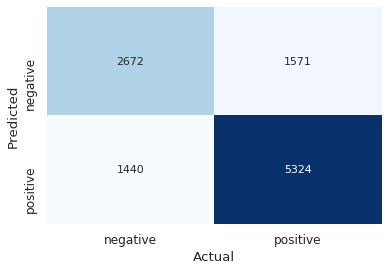

In [9]:
confusion = learner.evaluate()

cm_df = pd.DataFrame(confusion, class_names, class_names)
sns.set(font_scale=1.1, font='Arial')
ax = sns.heatmap(cm_df, cmap='Blues', annot=True, annot_kws={'size': 11}, cbar=False, fmt='g')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')